## Data Preparation 

### Loading Dataset

We will load the dataset for most relevant 95% DRGs

In [1]:
# Required packages
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import altair as alt
alt.renderers.enable('notebook')
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [2]:
# Importing the data
episode = pd.read_csv('D:/alber/Documents/TheRelevant95.csv', header = 0, sep=',', names = ['PatientID','IPEpisodeID','Gender Code',
                                                                     'Age On Admission','Birth Weight','ATSI Flag',
                                                                     'Admission Source Code','Admission Type Code',
                                                                     'Admission Specialty','Discharge Specialty',
                                                                     'Admission Ward Code','Discharge Ward Code',
                                                                     'Separation Method Code','DRG Code',
                                                                     'ICU LOS Hours','Total LOS Days','HITH Days',
                                                                     'LOS Type','WIES Value'])

episode.head()

,PatientID,IPEpisodeID,Gender Code,Age On Admission,Birth Weight,ATSI Flag,Admission Source Code,Admission Type Code,Admission Specialty,Discharge Specialty,Admission Ward Code,Discharge Ward Code,Separation Method Code,DRG Code,ICU LOS Hours,Total LOS Days,HITH Days,LOS Type,WIES Value
0,973538,3320175,M,56,NaN,No,T,P,HIHC,HIHC,F2B,FHITH,H,K01C,NaN,34,67.94,Multiday,8.3579
1,1198129,3327705,F,81,NaN,No,S,S,GBS,GBS,SHITH,SHITH,H,G70A,NaN,10,55.36,Multiday,4.0218
2,319442,3333120,M,82,NaN,No,H,C,45,26,F2C,FHITH,H,K01C,NaN,18,102.62,Multiday,6.7687
3,1210448,3353681,M,88,NaN,No,H,C,CRGS,UGIG,F2E,F3E,H,G02A,146.62,41,0.00,Multiday,9.5665
4,387487,3355364,M,72,NaN,No,H,C,IMSD,IMSD,S2A,S3E,S,F63A,NaN,59,0.00,Multiday,9.7236


### Checking for Missing Values

Let's make sure we do not have any missing values

In [3]:
episode.isna().sum()

PatientID                      0
IPEpisodeID                    0
Gender Code                    0
Age On Admission               0
Birth Weight              245181
ATSI Flag                      0
Admission Source Code          0
Admission Type Code            0
Admission Specialty            0
Discharge Specialty            0
Admission Ward Code            0
Discharge Ward Code            0
Separation Method Code         0
DRG Code                       0
ICU LOS Hours             245169
Total LOS Days                 0
HITH Days                      0
LOS Type                       0
WIES Value                     0
dtype: int64

In [4]:
# Removing the columns with missing values
# Splitting the data in target and given variables
dataAll = episode.drop(columns=['IPEpisodeID','PatientID','DRG Code','WIES Value','Birth Weight','ICU LOS Hours'])
targetAll = episode['WIES Value']

In [5]:
dataAll.isna().sum()

Gender Code               0
Age On Admission          0
ATSI Flag                 0
Admission Source Code     0
Admission Type Code       0
Admission Specialty       0
Discharge Specialty       0
Admission Ward Code       0
Discharge Ward Code       0
Separation Method Code    0
Total LOS Days            0
HITH Days                 0
LOS Type                  0
dtype: int64

### Encoding Categorical Features

Prior to modeling, it is essential to encode all categorical features (both the target feature and the descriptive features) into a set of numerical features.

In [6]:
# One hot encoding for categorical variables
categorical_cols = dataAll.columns[dataAll.dtypes==object].tolist()

for col in categorical_cols:
    n = len(dataAll[col].unique())
    if (n == 2):
        dataAll[col] = pd.get_dummies(dataAll[col], drop_first=True)
        
dataAll = pd.get_dummies(dataAll)

### Scaling of Features

After encoding all the categorical features, we perform a min-max scaling of the descriptive features.

In [7]:
# Retaining a copy of the original data
Data_dfAll = dataAll.copy()

# Apply Min-max scaling
Data_scaler = preprocessing.MinMaxScaler()

Data_scaler.fit(dataAll)
dataAll = Data_scaler.fit_transform(dataAll)

D:\alber\Documents\R\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\alber\Documents\R\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Feature Selection & Ranking

Let's have a look at the most important 10 features as selected by Random Forest Importance (RFI) in the full dataset. 
This is for a quick ranking of the most relevant 10 features to gain some insight into the problem at hand.

In [8]:
# Feature selection and ranking
num_features = 10
model_rfiAll = RandomForestRegressor(n_estimators=80, max_depth=15)
model_rfiAll.fit(dataAll, targetAll)
fs_indices_rfiAll = np.argsort(model_rfiAll.feature_importances_)[::-1][0:num_features]

best_features_rfiAll = Data_dfAll.columns[fs_indices_rfiAll].values
print(best_features_rfiAll)

feature_importances_rfiAll = model_rfiAll.feature_importances_[fs_indices_rfiAll]
feature_importances_rfiAll

['LOS Type_Multiday' 'Total LOS Days' 'LOS Type_Same day'
 'Age On Admission' 'Discharge Specialty_44' 'Admission Ward Code_FDPU'
 'Admission Type Code_P' 'Admission Specialty_7' 'Discharge Specialty_DUA'
 'Discharge Specialty_CRGS']


array([0.4857134 , 0.26005406, 0.04700439, 0.02268351, 0.01879055,
       0.01196935, 0.008558  , 0.00791199, 0.00730819, 0.00568784])

In [9]:
def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.85, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

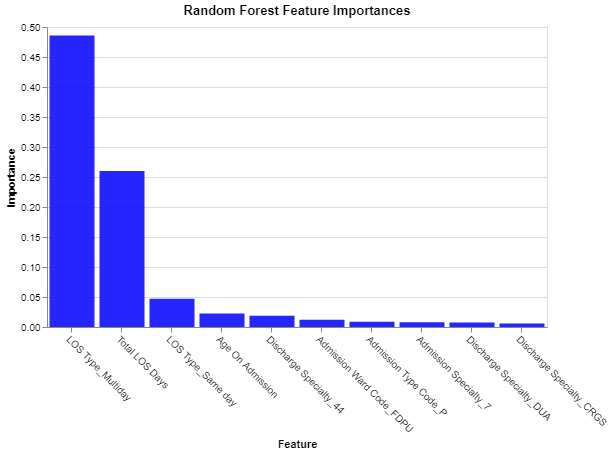

In [10]:
plot_imp(best_features_rfiAll, feature_importances_rfiAll, 'Random Forest', 'blue')

### Data Sampling & Train-Test Splitting

The original dataset has around 250K rows, which is a lot. So, we would like to work with a small sample here with 20K rows. Thus, we will do the following:

- Randomly select 20K rows from the full dataset.
- Split this sample into train and test partitions with a 70:30 ratio using stratification.

In [8]:
# Data sampling
n_samples = 30000

dataAll_sample = pd.DataFrame(dataAll).sample(n=n_samples, random_state=8).values
targetAll_sample = pd.DataFrame(targetAll).sample(n=n_samples, random_state=8).values

print(dataAll_sample.shape)
print(targetAll_sample.shape)

(30000, 311)
(30000, 1)


In [9]:
# Train-test splitting
from sklearn.model_selection import train_test_split

dataAll_sample_train, dataAll_sample_test, \
targetAll_sample_train, targetAll_sample_test = train_test_split(dataAll_sample, targetAll_sample, 
                                                    test_size = 0.3, random_state=999)

print(dataAll_sample_train.shape)
print(dataAll_sample_test.shape)

(21000, 311)
(9000, 311)


## Modelling

In [10]:
# 5-fold stratified cross-validation evaluation method for hyperparameter tuning.

from sklearn.model_selection import KFold, GridSearchCV
cv_method = KFold(n_splits=5, random_state=999)

### Random Forest

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestRegressor
        from numpy import argsort
        model_rfi = RandomForestRegressor(n_estimators=80, max_depth=15)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [12]:
pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', RandomForestRegressor())])


params_pipe_DT = {'rfi_fs__n_features_': [290, dataAll.shape[1]],
                  'dt__max_depth': [21, 24, 27],
                  'dt__min_samples_split': [25, 28,32]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          verbose=2) 

gs_pipe_DT.fit(dataAll_sample_train, targetAll_sample_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed: 24.2min finished
D:\alber\Documents\R\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\alber\Documents\R\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\alber\Documents\R\Anaconda\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [13]:
gs_pipe_DT.best_params_

{'dt__max_depth': 21, 'dt__min_samples_split': 25, 'rfi_fs__n_features_': 311}

In [14]:
gs_pipe_DT.best_score_

0.7485165468992472

In [15]:
tree_mse = mean_squared_error(targetAll_sample_train, gs_pipe_DT.predict(dataAll_sample_train))
tree_mae = mean_absolute_error(targetAll_sample_train, gs_pipe_DT.predict(dataAll_sample_train))
print("Random Forest training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))

Random Forest training mse =  0.09657170840653054  & mae =  0.13583895055168024  & rmse =  0.31075988867054666


In [16]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [17]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
1,0.748517,0.014485,0.766443,0.729759,21.0,25.0,311.0
7,0.747510,0.015273,0.769247,0.732957,24.0,25.0,311.0
16,0.747160,0.016854,0.770085,0.726852,27.0,32.0,290.0
0,0.745649,0.011259,0.762980,0.734280,21.0,25.0,290.0
12,0.744422,0.018244,0.770497,0.719079,27.0,25.0,290.0


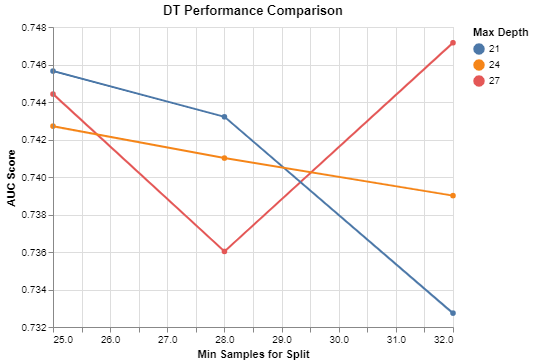

In [18]:
results_DT_10_features = results_DT[results_DT['rfi_fs__n_features_'] == 290.0]

alt.Chart(results_DT_10_features, 
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('dt__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__max_depth:N', title='Max Depth')
)


### Ridge Regression

In [19]:
from sklearn.linear_model import LinearRegression, BayesianRidge, SGDRegressor, Ridge

pipe_BR = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('lr', Ridge())])


params_pipe_BR = {'rfi_fs__n_features_': [130, 170, 210, 250, 290, dataAll.shape[1]],
                  }

gs_pipe_BR = GridSearchCV(estimator=pipe_BR, 
                          param_grid=params_pipe_BR, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          verbose=2) 

gs_pipe_BR.fit(dataAll_sample_train, targetAll_sample_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  5.9min finished
D:\alber\Documents\R\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=KFold(n_splits=5, random_state=999, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rfi_fs', RFIFeatureSelector(n_features_=10)), ('lr', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'rfi_fs__n_features_': [130, 170, 210, 250, 290, 311]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [20]:
gs_pipe_BR.best_params_

{'rfi_fs__n_features_': 290}

In [21]:
gs_pipe_BR.best_score_

0.7437154042616463

In [22]:
tree_mse = mean_squared_error(targetAll_sample_train, gs_pipe_BR.predict(dataAll_sample_train))
tree_mae = mean_absolute_error(targetAll_sample_train, gs_pipe_BR.predict(dataAll_sample_train))
print("Reg training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))

Reg training mse =  0.132290119814397  & mae =  0.17472474521788942  & rmse =  0.3637170876029844


In [23]:
results_BR = get_search_results(gs_pipe_BR)
results_BR

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_
4,0.743715,0.013039,0.760744,0.727708,290.0
3,0.743694,0.013092,0.760635,0.727616,250.0
5,0.743682,0.012994,0.760782,0.727745,311.0
2,0.743651,0.012683,0.759776,0.727641,210.0
1,0.741759,0.012140,0.756156,0.725942,170.0
0,0.738353,0.012511,0.753236,0.721508,130.0


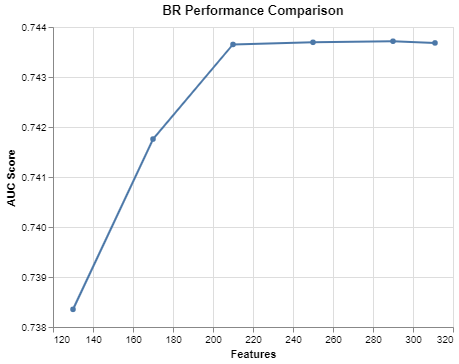

In [24]:
alt.Chart(results_BR, 
          title='BR Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('rfi_fs__n_features_', title='Features'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

### Neural Network

In [25]:
from sklearn.neural_network import MLPRegressor

pipe_NN = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', MLPRegressor())])


params_pipe_NN = {'rfi_fs__n_features_': [25, 29, 33],
                   'dt__hidden_layer_sizes': [80, 90, 95, 105]}
                  #  'dt__solver': ['lbfgs', 'sgd', 'adam']}

gs_pipe_NN = GridSearchCV(estimator=pipe_NN, 
                          param_grid=params_pipe_NN, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          verbose=2) 

gs_pipe_NN.fit(dataAll_sample_train, targetAll_sample_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed: 17.1min finished
D:\alber\Documents\R\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\alber\Documents\R\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
gs_pipe_NN.best_params_

{'dt__hidden_layer_sizes': 80, 'rfi_fs__n_features_': 33}

In [27]:
gs_pipe_NN.best_score_

0.7348099950542025

In [28]:
tree_mse = mean_squared_error(targetAll_sample_train, gs_pipe_NN.predict(dataAll_sample_train))
tree_mae = mean_absolute_error(targetAll_sample_train, gs_pipe_NN.predict(dataAll_sample_train))
print("NN training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))

NN training mse =  0.11211764414780655  & mae =  0.17254456917914598  & rmse =  0.3348397290463104


In [29]:
results_NN = get_search_results(gs_pipe_NN)
results_NN

,mean_score,std_score,max_score,min_score,dt__hidden_layer_sizes,rfi_fs__n_features_
2,0.734810,0.017609,0.759458,0.713151,80.0,33.0
8,0.734800,0.023251,0.769480,0.701091,95.0,33.0
0,0.732972,0.022361,0.756238,0.693926,80.0,25.0
10,0.732052,0.023008,0.760491,0.693828,105.0,29.0
11,0.731989,0.013573,0.748573,0.716960,105.0,33.0
1,0.731776,0.017158,0.758589,0.715775,80.0,29.0
5,0.731252,0.016688,0.757680,0.707670,90.0,33.0
7,0.731245,0.015921,0.749186,0.711308,95.0,29.0
6,0.730030,0.019630,0.751982,0.694765,95.0,25.0
3,0.726951,0.019043,0.749644,0.693318,90.0,25.0


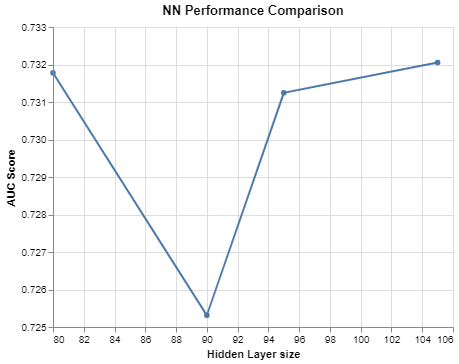

In [30]:
results_NN_10_features = results_NN[results_NN['rfi_fs__n_features_'] == 29.0]

alt.Chart(results_NN_10_features, 
          title='NN Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('dt__hidden_layer_sizes', title='Hidden Layer size'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

## Testing Models

In [31]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = KFold(n_splits=10, random_state=111)

cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                 X=dataAll_sample_test,
                                 y=targetAll_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2)
cv_results_DT.mean()

0.7305017386524136

In [32]:
cv_results_BR = cross_val_score(estimator=gs_pipe_BR.best_estimator_,
                                 X=dataAll_sample_test,
                                 y=targetAll_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2)
cv_results_BR.mean()

0.7317914194778711

In [36]:
cv_results_NN = cross_val_score(estimator=gs_pipe_NN.best_estimator_,
                                 X=dataAll_sample_test,
                                 y=targetAll_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2)
cv_results_NN.mean()

0.6848329559010012

## Predicting WIES

In [33]:
print ("Total actual WIES - ", targetAll_sample_test.sum())

Total actual WIES -  5300.0606


In [34]:
print ("Pedicted WIES by Random Forest -" ,gs_pipe_DT.predict(dataAll_sample_test).sum())
print ("Pedicted WIES by Ridge Regression -" ,gs_pipe_BR.predict(dataAll_sample_test).sum())
print ("Pedicted WIES by Neural Network -" ,gs_pipe_NN.predict(dataAll_sample_test).sum())

Pedicted WIES by Random Forest - 5348.260290725395
Pedicted WIES by Ridge Regression - 5350.482809437167
Pedicted WIES by Neural Network - 5454.068879323606


In [35]:
# Saving the model
import pickle

DT_PredictWIES = 'PredictWIES.sav'
pickle.dump(gs_pipe_DT, open(DT_PredictWIES,'wb'))

In [36]:
# Testing the predicted model
WIES_model = pickle.load(open(DT_PredictWIES, 'rb'))
#result = loaded_model.score(dataAll_sample_test, targetAll_sample_test)
prediction = WIES_model.predict(dataAll_sample_test).sum()

print("Predicted WIES Value -", prediction)

Predicted WIES Value - 5348.260290725395
